# Identifying parts of recipe ingredients

We're going to use transformers to train a recipe ingredient phrase tagger.

We will follow the techniques used in Chapter 4 of [Natural Language Processing with Transformers](https://www.oreilly.com/library/view/natural-language-processing/9781098103231/) by Tunstall, von Werra and Wolf (in particular see their [chapter 4 notebook](https://github.com/nlp-with-transformers/notebooks)).

We will use the data from [A Named Entity Based Approach to Model Recipes, by Diwan, Batra, and Bagler](https://arxiv.org/abs/2004.12184).
There are other existing datasets such as [NYTimes Ingredient Phrase Tagger](https://github.com/nytimes/ingredient-phrase-tagger).

In [1]:
push_to_hub = False

from huggingface_hub import notebook_login

if push_to_hub:
    notebook_login()

In [2]:
if push_to_hub:
    !sudo apt-get install git-lfs
    !git lfs install

# Fetching the Data

The source data is from [A Named Entity Based Approach to Model Recipes, by Diwan, Batra, and Bagler](https://arxiv.org/abs/2004.12184).
They annotated data from from RecipeDB sources AllRecipes (`ar`), and FOOD.com (formerly GeniusKitchen.com, `gk`).
They have generously [shared the training data](https://github.com/cosylabiiit/recipe-knowledge-mining).

In particular we are interested in the annotated ingredience for each source.
Let's fetch the most recent version from Github:

In [3]:
import requests

data_sources = ['ar', 'gk']
data_splits = ['train', 'test']

base_url = 'https://raw.githubusercontent.com/cosylabiiit/recipe-knowledge-mining/master/'
def get_text(source: str, split: str) -> str:
    r = requests.get(base_url + f'{source}_{split}.tsv')
    r.raise_for_status()
    content = r.content.decode('utf-8')
    return list(segment_texts(content))

The texts are as TSVs where each line is a tab separated token and label.
Different ingredients are separated by blank lines.

We'll convert this into a list of pairs of text, token.

In [4]:
sample="""	
4	QUANTITY
cloves	UNIT
garlic	NAME
	
2	QUANTITY
tablespoons	UNIT
vegetable	NAME
oil	NAME
,	O
divided	STATE
	
2	QUANTITY
tablespoons	UNIT
dried	DF
marjoram	NAME
	"""

In [5]:
tag_names = ['O', 'QUANTITY', 'UNIT', 'STATE', 'NAME', 'DF', 'SIZE', 'TEMP']

In [6]:
from typing import List, Tuple

def segment_texts(data: str) -> List[Tuple[str, str]]:
    output = []
    for line in data.split('\n'):
        if line.strip():
            text, token = line.split('\t')
            output.append((text.strip(), token.strip()))
        elif output:
            yield output
            output = []

In [7]:
for line in segment_texts(sample):
    print(line)

[('4', 'QUANTITY'), ('cloves', 'UNIT'), ('garlic', 'NAME')]
[('2', 'QUANTITY'), ('tablespoons', 'UNIT'), ('vegetable', 'NAME'), ('oil', 'NAME'), (',', 'O'), ('divided', 'STATE')]
[('2', 'QUANTITY'), ('tablespoons', 'UNIT'), ('dried', 'DF'), ('marjoram', 'NAME')]


Converting to IOB-1.

Because this isn't in the text itself we're going to infer any adjacent tags are a compound; this may not be true.

In [8]:
def convert_to_iob1(tokens):
    return ['I-' + label if label != 'O' else 'O' for label in tokens]

assert convert_to_iob1(['QUANTITY', 'SIZE', 'NAME', 'NAME', 'O', 'STATE']) == ['I-QUANTITY', 'I-SIZE', 'I-NAME', 'I-NAME', 'O', 'I-STATE']

Then we want to wrap this in a HuggingFace dataset.

This requires flipping them into aligned sequences of tokens and labels, which we can do with `zip(*...)`.

In [9]:
iob_names = convert_to_iob1(tag_names)

In [10]:
from datasets import Dataset, Features, Sequence, Value, ClassLabel

_features = Features(
    tokens=Sequence(Value(dtype='string')),
    labels=Sequence(ClassLabel(names=iob_names))
)

def convert_to_dataset(data):
    all_tokens = []
    all_labels = []
    for datum in data:
        tokens, labels = zip(*datum)
        all_tokens.append(tokens)
        all_labels.append(convert_to_iob1(labels))
        
    return Dataset.from_dict({'tokens': all_tokens, 'labels': all_labels},
                             _features)

Then we can wrap it all together to get the datasets.

In [11]:
from datasets import DatasetDict

data = {source: DatasetDict({split: convert_to_dataset(get_text(source, split)) for split in data_splits}) for source in data_sources}

In [12]:
data['gk']['train'][0]

{'tokens': ['2',
  'cups',
  'cooked',
  'corned',
  'beef',
  '-LRB-',
  'or',
  'canned',
  '-RRB-'],
 'labels': [1, 2, 3, 3, 4, 0, 0, 0, 0]}

We can reproduce Table III from the paper on Dataset Sizes

In [13]:
import pandas as pd

(
    pd.DataFrame(
        [(source, split, len(datum)) for source, source_data in data.items() for split, datum in source_data.items()],
        columns=['source', 'split', 'n'])
    .pivot(index='split', columns='source', values='n')
    .sort_values('ar', ascending=False)
    .assign(both = lambda _: _.sum(axis=1))
)

source,ar,gk,both
split,,,
train,1470,5142,6612
test,483,1705,2188


## Creating Validation Splits

The paper did not have a separate validation split, so let us create one.

In [14]:
val_size = 0.2
seed = 42

for source in data:
    if 'validation' not in data[source]:
        train_val = data[source]['train'].train_test_split(test_size=val_size, seed=seed)
        data[source]['train'] = train_val['train']
        data[source]['validation'] = train_val['test']

In [15]:
(
    pd.DataFrame(
        [(source, split, len(datum)) for source, source_data in data.items() for split, datum in source_data.items()],
        columns=['source', 'split', 'n'])
    .pivot(index='split', columns='source', values='n')
    .sort_values('ar', ascending=False)
    .assign(both = lambda _: _.sum(axis=1))
)

source,ar,gk,both
split,,,
train,1176,4113,5289
test,483,1705,2188
validation,294,1029,1323


# Examining data

## Tags

In [16]:
tag_feature = data['gk']['train'].features['labels'].feature

We need a little helper function to convert the integer labels into a Pandas categorical dtype.

In [17]:
def convert_int_to_categorical(df: pd.DataFrame, col_name: str, names: List[str], copy=True) -> pd.DataFrame:
    if copy:
        df = df.copy()
    int2str = dict(enumerate(names))
    df[col_name] = df[col_name].map(int2str)
    df[col_name] = pd.Categorical(df[col_name], categories=names)
    return df

In [18]:
df_train = (pd.concat([pd.DataFrame(data[source]['train']).assign(source=source) for source in data_sources],
                      ignore_index=True)
            .apply(lambda _: _.explode())
            .pipe(convert_int_to_categorical, 'labels', tag_feature.names)
            .reset_index()
           )

df_train.head()

,index,tokens,labels,source
0,0,1,I-QUANTITY,ar
1,0,teaspoon,I-UNIT,ar
2,0,ground,I-STATE,ar
3,0,mace,I-NAME,ar
4,1,1/2,I-QUANTITY,ar


## How frequent are the tags?

In [19]:
df_tag_count = (
    df_train
    .groupby(['source', 'labels'])
    .agg(n=('index', 'count'))
    .reset_index()
    .pivot('labels', 'source', 'n')
    .sort_values(data_sources[0], ascending=False)
)
df_tag_count

source,ar,gk
labels,,
I-NAME,2006,6801
O,1349,6658
I-QUANTITY,1273,3914
I-UNIT,1085,3257
I-STATE,706,1885
I-DF,127,358
I-SIZE,47,247
I-TEMP,26,91


We can see TEMP, SIZE and DF (Dried/Fresh) are pretty uncommon and it will be hard to do well on them.

<AxesSubplot:ylabel='labels'>

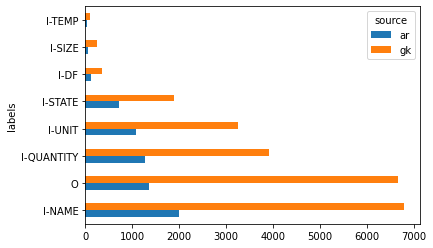

In [20]:
df_tag_count.plot.barh()

Another way to view it is how many sentences have each kind of tag,

Almost every exmaple has a name (as it should)

In [21]:
df_tag_sentence_count = (
    df_train
    .groupby(['source', 'labels'])
    .agg(n=('index', 'nunique'))
    .reset_index()
    .pivot('labels', 'source', 'n')
    .sort_values(data_sources[0], ascending=False)
)

source_sentence_count = df_train.groupby('source').index.nunique()

(df_tag_sentence_count / source_sentence_count).style.format('{:0.1%}')

source,ar,gk
labels,,
I-NAME,99.4%,99.6%
I-QUANTITY,97.8%,93.6%
I-UNIT,81.8%,77.8%
I-STATE,48.0%,38.4%
O,43.9%,45.9%
I-DF,10.8%,8.6%
I-SIZE,3.9%,6.0%
I-TEMP,2.0%,2.2%


<AxesSubplot:ylabel='labels'>

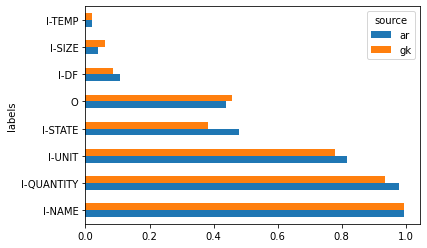

In [22]:
(df_tag_sentence_count / source_sentence_count).plot.barh()

In [23]:
name_counts = df_train.assign(is_name=lambda _: _.labels=='I-NAME').groupby('index')['is_name'].sum()

df_train_no_name = df_train[df_train['index'].isin(name_counts[name_counts==0].index)]

It seems in each of the examples with a missing NAME tag there is an annotation error; e.g.

* 118: zuchhinis should be NAME
* 203: thyme should be NAME
* 698: sake should be NAME
* 839: pecans should be NAME
* 896: No NAME here, but 12-inch is not a quantitiy.

In [24]:
from itertools import groupby, islice
from IPython.display import display

n_example = 5

groups = groupby((row for idx, row in df_train_no_name.iterrows()), key=lambda row: row['index'])
groups = islice(groups, n_example)

for idx, group in groups:
    index, tokens, tags, source = zip(*group)
    print(source[0], idx)
    display(pd.DataFrame({'tokens': tokens, 'tags': tags}).T)

ar 118


,0,1,2,3,4,5,6,7
tokens,2,zucchinis,",",cut,into,4,large,chunks
tags,I-QUANTITY,O,O,I-STATE,O,O,I-SIZE,O


ar 203


,0,1,2,3
tokens,1/4,teaspoon,dried,thyme
tags,I-QUANTITY,I-UNIT,I-DF,O


ar 698


,0,1,2,3,4,5,6
tokens,3,tablespoons,sake,",",or,to,taste
tags,I-QUANTITY,I-UNIT,O,O,O,O,O


ar 839


,0,1,2,3
tokens,1/2,cup,chopped,pecans
tags,I-QUANTITY,I-UNIT,I-STATE,I-STATE


ar 896


,0,1,2,3,4
tokens,4,12-inch,long,metal,skewers
tags,I-QUANTITY,I-QUANTITY,I-UNIT,O,O


### Most common tokens per tag

For each tag what is the most common tokens and their frequency.

I can quickly see some linguistic features (NAME is almost always a noune, STATE almost always a verb).

SIZE, DF, TEMP and UNIT could probably be captured using a gazette.
QUANTITY could be captured using some rules.

In [25]:
topn = 10
import numpy as np

(df_train
 .groupby(['labels', 'tokens'])
 .agg(n=('index', 'count'), n_sentence=('index', 'nunique'), n_source=('source', 'nunique'))
 .sort_values('n', ascending=False)
 .reset_index()
 .groupby('labels')
 .pipe(lambda _: pd.DataFrame({**{f'token_{i}': np.where(_.n.nth(i) > 0, _.tokens.nth(i), '') for i in range(topn)}, **{f'prop_{i}': _.n.nth(i)/ _.n.sum() for i in range(topn)}}))
).style.format({f'prop_{i}': '{:0.2%}' for i in range(topn)})

,token_0,token_1,token_2,token_3,token_4,token_5,token_6,token_7,token_8,token_9,prop_0,prop_1,prop_2,prop_3,prop_4,prop_5,prop_6,prop_7,prop_8,prop_9
labels,,,,,,,,,,,,,,,,,,,,
O,",",-LRB-,-RRB-,or,and,to,into,taste,finely,optional,21.34%,8.48%,8.47%,4.10%,3.40%,2.00%,1.82%,1.31%,1.19%,1.11%
I-QUANTITY,1,2,1/2,1/4,3,4,1 1/2,3/4,6,8,31.64%,14.69%,11.34%,6.46%,5.53%,4.86%,3.01%,2.31%,2.22%,1.91%
I-UNIT,cup,teaspoon,tablespoons,cups,tablespoon,teaspoons,ounces,ounce,can,g,23.28%,12.92%,9.77%,8.68%,6.38%,4.84%,4.01%,3.39%,3.32%,3.06%
I-STATE,chopped,ground,sliced,cut,diced,grated,minced,peeled,shredded,drained,17.33%,7.64%,7.26%,5.29%,5.25%,3.86%,3.78%,3.71%,3.09%,2.55%
I-NAME,pepper,cheese,sugar,onion,oil,garlic,red,sauce,water,butter,2.58%,2.41%,2.16%,1.98%,1.86%,1.77%,1.75%,1.65%,1.49%,1.45%
I-DF,fresh,dried,dry,freshly,light,torn,refrigerated,,,,56.70%,20.41%,10.72%,7.01%,4.54%,0.41%,0.21%,0.00%,0.00%,0.00%
I-SIZE,large,medium,small,long,big,8-inch,medum,medium-large,extra-large,,45.24%,27.55%,24.49%,0.68%,0.68%,0.34%,0.34%,0.34%,0.34%,0.00%
I-TEMP,hot,frozen,warm,cold,lukewarm,refrigerated,heated,temperature,room,cooled,34.19%,31.62%,13.68%,8.55%,3.42%,2.56%,1.71%,1.71%,1.71%,0.85%


# Lengths

Most of these are very short and will easily fit into a context window

<AxesSubplot:title={'center':'n_tokens'}, xlabel='source'>

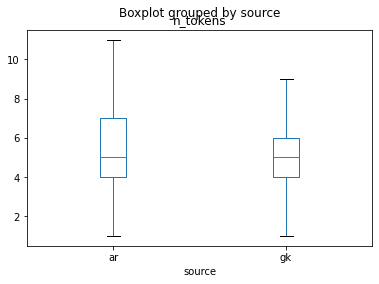

In [26]:
df_train_len = (df_train
 .groupby(['source', 'index'])
 .agg(n_tokens=('tokens', 'count'))
 .reset_index()
)

df_train_len.boxplot('n_tokens', by='source', grid=False, showfliers=False)

In [27]:
(df_train_len
 .groupby('source')
 .agg(min=('n_tokens', 'min'),
      med=('n_tokens', 'median'),
      mean=('n_tokens', 'mean'),
      max=('n_tokens', 'max'),
     )
)

,min,med,mean,max
source,,,,
ar,1,5.0,5.628401,18
gk,1,5.0,5.643326,29


## Common Tokens

It seems like `-LRB-` and `-RRB-` are special tokens for "Left Round Bracket" and "Right Round Bracket" (i.e `(` and `)`)

In [28]:
(
    df_train
    .groupby('tokens')
    .agg(tag=('labels', pd.Series.mode), n=('index', 'count'))
    .sort_values('n', ascending=False)
    .assign(p = lambda _: _['n'] / sum(_['n']))
    .head(20)
)

,tag,n,p
tokens,,,
1,I-QUANTITY,1714,0.057459
",",O,1712,0.057392
cup,I-UNIT,1049,0.035166
2,I-QUANTITY,800,0.026819
-LRB-,O,679,0.022762
-RRB-,O,678,0.022729
1/2,I-QUANTITY,613,0.020550
teaspoon,I-UNIT,570,0.019108
chopped,I-STATE,453,0.015186


These seem to be the only special tokens

In [29]:
df_train[df_train.tokens.str.match('^-.*-$')].tokens.value_counts()

-LRB-    679
-RRB-    678
--         1
Name: tokens, dtype: int64

They'll cause our tokenizer some problems so let's fix them up

In [30]:
def fixup_token(token):
    if token == '-LRB-':
        return '('
    elif token == '-RRB-':
        return ')'
    else:
        return token
    
def map_fixup_tokens(examples):
    examples['tokens'] = [fixup_token(token) for token in examples['tokens']]
    return examples

In [31]:
data['ar']['train'].select(range(2)).map(map_fixup_tokens)['tokens']

0ex [00:00, ?ex/s]

[['1', 'teaspoon', 'ground', 'mace'],
 ['1/2', '(', '13.5', 'ounce', ')', 'can', 'chopped', 'spinach']]

# Preparing Model

In [32]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification, Trainer
import torch

In [33]:
tag_feature = data['gk']['train'].features['labels'].feature

In [34]:
tag_feature.num_classes

8

In [35]:
model_ckpt = 'xlm-roberta-base'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForTokenClassification.from_pretrained(model_ckpt, num_labels=tag_feature.num_classes).to(device)
collator = DataCollatorForTokenClassification(tokenizer)

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-st

Let's run some examples

In [36]:
examples = data['ar']['train'].select(range(2)).map(map_fixup_tokens)

0ex [00:00, ?ex/s]

Tokenizing

In [37]:
examples[:]

{'tokens': [['1', 'teaspoon', 'ground', 'mace'],
  ['1/2', '(', '13.5', 'ounce', ')', 'can', 'chopped', 'spinach']],
 'labels': [[1, 2, 3, 4], [1, 0, 1, 2, 0, 2, 3, 4]]}

First we tokenize

In [38]:
inputs = tokenizer(examples['tokens'], is_split_into_words=True)
inputs

{'input_ids': [[0, 106, 26156, 11955, 191, 61585, 291, 329, 2], [0, 22128, 15, 5847, 758, 6, 85018, 1388, 831, 681, 48398, 25927, 934, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [39]:
pd.DataFrame({'tokens': tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]),
              'word_ids': inputs.word_ids(0)}).T

,0,1,2,3,4,5,6,7,8
tokens,<s>,▁1,▁tea,spo,on,▁ground,▁ma,ce,</s>
word_ids,NaN,0.0,1.0,1.0,1.0,2.0,3.0,3.0,NaN


In [40]:
pd.DataFrame({'tokens': tokenizer.convert_ids_to_tokens(inputs['input_ids'][1]),
              'word_ids': inputs.word_ids(1)}).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
tokens,<s>,▁1/2,▁(,▁13.,5,▁,ounce,▁),▁can,▁cho,pped,▁spin,ach,</s>
word_ids,NaN,0.0,1.0,2.0,2.0,3.0,3.0,4.0,5.0,6.0,6.0,7.0,7.0,NaN


We need to realign the labels

In [41]:
IGN = -100
def align_labels(labels, word_ids):
    last_idx = None
    output = []
    for idx in word_ids:
        if idx is not None and idx != last_idx:
            output.append(labels[idx])
        else:
            output.append(IGN)
        last_idx = idx
    return output

In [42]:
(
    pd.DataFrame({'tokens': tokenizer.convert_ids_to_tokens(inputs['input_ids'][1]),
              'word_ids': inputs.word_ids(1),
              'labels': align_labels(examples['labels'][1], inputs.word_ids(1))}
            )
.assign(label_str = lambda _: [tag_feature.int2str(t) if t != -100 else 'IGN' for t in _.labels])
    .T
)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
tokens,<s>,▁1/2,▁(,▁13.,5,▁,ounce,▁),▁can,▁cho,pped,▁spin,ach,</s>
word_ids,NaN,0.0,1.0,2.0,2.0,3.0,3.0,4.0,5.0,6.0,6.0,7.0,7.0,NaN
labels,-100,1,0,1,-100,2,-100,0,2,3,-100,4,-100,-100
label_str,IGN,I-QUANTITY,O,I-QUANTITY,IGN,I-UNIT,IGN,O,I-UNIT,I-STATE,IGN,I-NAME,IGN,IGN


Then we put it into the model

In [43]:
def tokenize_and_align(examples):
    tokenized_inputs = tokenizer(examples['tokens'], is_split_into_words=True, truncation=True)
    tokenized_inputs['labels'] = align_labels(examples['labels'], tokenized_inputs.word_ids())
    return tokenized_inputs

In [44]:
encoded_examples = examples.map(tokenize_and_align, remove_columns=['tokens'])

0ex [00:00, ?ex/s]

In [45]:
inputs = collator([encoded_examples[idx] for idx in range(2)], return_tensors='pt')
inputs

{'labels': tensor([[-100,    1,    2, -100, -100,    3,    4, -100, -100, -100, -100, -100,
          -100, -100],
         [-100,    1,    0,    1, -100,    2, -100,    0,    2,    3, -100,    4,
          -100, -100]]),
 'input_ids': tensor([[    0,   106, 26156, 11955,   191, 61585,   291,   329,     2,     1,
              1,     1,     1,     1],
         [    0, 22128,    15,  5847,   758,     6, 85018,  1388,   831,   681,
          48398, 25927,   934,     2]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [46]:
label_ids = inputs['labels']
label_ids.shape

torch.Size([2, 14])

In [47]:
preds = model(input_ids=inputs['input_ids'].to(device), attention_mask=inputs['attention_mask'].to(device))

We get: bs x seq_length x num_labels

In [48]:
predictions = preds.logits
predictions.shape

torch.Size([2, 14, 8])

In [49]:
del model
del preds

In [50]:
data_encoded = {source: ds.map(map_fixup_tokens).map(tokenize_and_align, remove_columns=['tokens']) for source, ds in data.items()}

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

## Evaluating a prediction

To evaluate our predictions we need to align them back with the original labels.
This is almost the inverse of padding with the -100 tags.

In [51]:
tag_feature

ClassLabel(num_classes=8, names=['O', 'I-QUANTITY', 'I-UNIT', 'I-STATE', 'I-NAME', 'I-DF', 'I-SIZE', 'I-TEMP'], id=None)

In [52]:
from itertools import compress
import numpy as np

def align_predictions(predictions, label_ids, int2str=tag_feature.names):
    preds = np.argmax(predictions, axis=-1)
    batch_size, seq_len = preds.shape
    
    y_true = []
    y_pred = []
    for pred, label in zip(preds, label_ids):
        mask = [l != IGN for l in label]
        y_true.append([int2str[l] for l in compress(label, mask)])
        y_pred.append([int2str[l] for l in compress(pred, mask)])
    
    return y_true, y_pred

In [53]:
y_true, y_pred = align_predictions(predictions.cpu().detach().numpy(), label_ids.cpu().detach().numpy())
y_true, y_pred

([['I-QUANTITY', 'I-UNIT', 'I-STATE', 'I-NAME'],
  ['I-QUANTITY',
   'O',
   'I-QUANTITY',
   'I-UNIT',
   'O',
   'I-UNIT',
   'I-STATE',
   'I-NAME']],
 [['O', 'I-TEMP', 'I-TEMP', 'O'],
  ['O', 'O', 'O', 'O', 'I-STATE', 'O', 'O', 'I-TEMP']])

In [54]:
!pip install seqeval

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     |████████████████████████████████| 43 kB 908 kB/s             
  Preparing metadata (setup.py) ... - done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=4887e17d28f8f2e026abba028880614834608b4e9eeaa532d83a5203cbadd9f2
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [55]:
from seqeval.metrics import f1_score

In [56]:
f1_score(y_true, y_pred)

0.0

In [57]:
f1_score([['I-QUANTITY', 'I-UNIT', 'I-STATE', 'I-NAME']], [['I-QUANTITY', 'O', 'O', 'O']])

0.4

# Baseline

A simple baseline is to assign each word to the most common tag.

Ideally I'd use the pipeline above, but it's a touch tricky.

In [58]:
most_common_token = df_train.groupby('tokens').agg(label=('labels', lambda x: pd.Series.mode(x)[0]))['label'].to_dict()

In [59]:
%%time
preds = {}
actual = {}
tokens = {}

eval_split = 'validation'

for source in data_sources:
    preds[source] = []
    actual[source] = []
    for item in data[source][eval_split]:
        actual[source].append(tag_feature.int2str(item['labels']))
        preds[source].append([most_common_token.get(t, 'O') for t in item['tokens']])

CPU times: user 144 ms, sys: 52 µs, total: 144 ms
Wall time: 143 ms


This simple model gives an f1 scores in the mid 90s.
They are only a couple of percentage points lower than the CRF in the original paper.

In [60]:
for source in data_sources:
    print(source, f1_score(actual[source], preds[source]))

ar 0.953759925268566
gk 0.9213137665967854


Looking by label: the most common mistakes are mispredicting terms for "O", especially "NAME".

In [61]:
preds_flat = {source: [l for row in preds[source] for l in row] for source in data_sources}
actuals_flat = {source: [l for row in actual[source] for l in row] for source in data_sources}


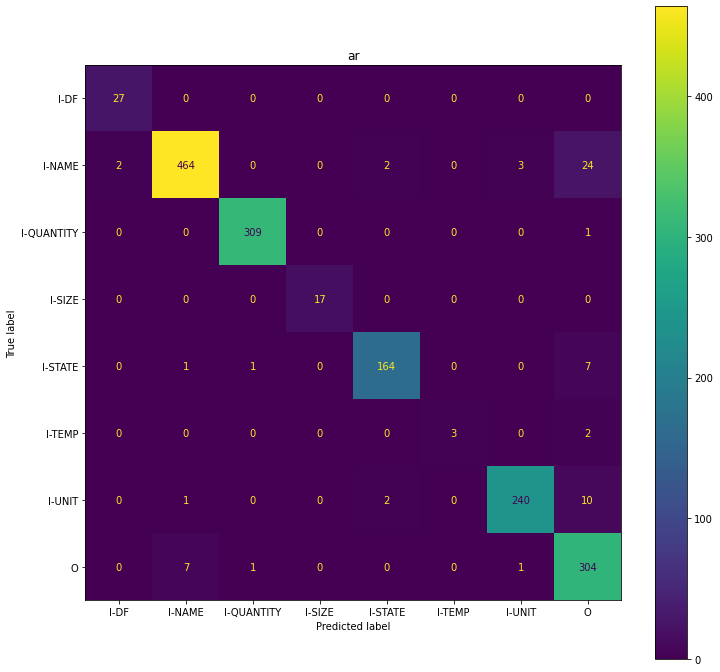

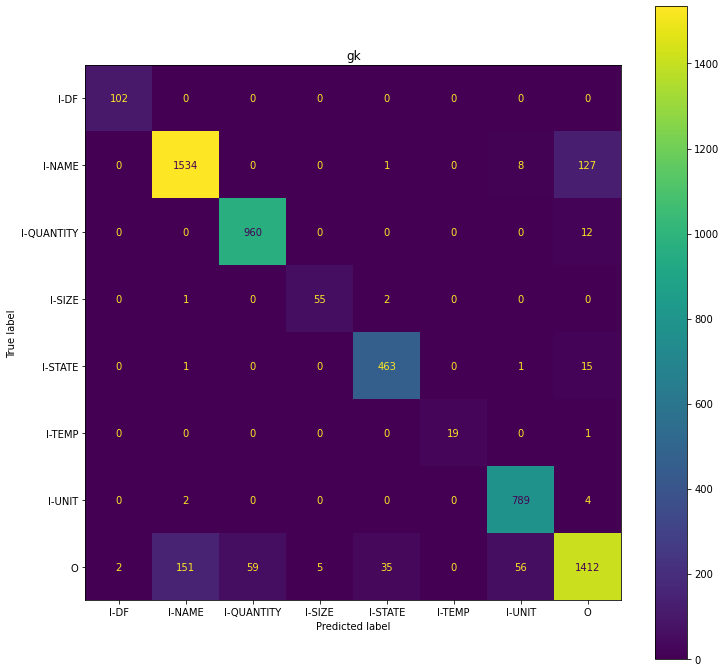

In [62]:
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt


for source in data_sources:
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.set_title(source)
    ConfusionMatrixDisplay.from_predictions(actuals_flat[source], preds_flat[source], ax=ax)

What are the confused tags?

In [63]:
tokens_flat = {source: [t for s in data[source][eval_split]['tokens'] for t in s] for source in data_sources}

In [64]:
mismatch = []
for source in data_sources:
    for label, pred, token in zip(actuals_flat[source], preds_flat[source], tokens_flat[source]):
        if label != pred and label != 'O' and pred != 'O':
            mismatch.append((token, label, pred))

The most common mistake is whether cloves is a unit or a name.

In [65]:
(
    pd.DataFrame(mismatch, columns=['token', 'actual', 'pred'])
    .assign(n=1)
    .groupby(['token', 'actual', 'pred'])
    .count()
    .sort_values('n', ascending=False)
)

n
token       actual  pred         
cloves      I-NAME  I-UNIT      7
firm        I-STATE I-NAME      2
halved      I-UNIT  I-STATE     2
sprig       I-UNIT  I-NAME      2
2           I-STATE I-QUANTITY  1
peeled      I-SIZE  I-STATE     1
stewing     I-STATE I-UNIT      1
            I-NAME  I-UNIT      1
sliced      I-SIZE  I-STATE     1
short       I-SIZE  I-NAME      1
sheet       I-NAME  I-UNIT      1
light       I-NAME  I-DF        1
mild        I-NAME  I-STATE     1
bags        I-NAME  I-UNIT      1
head        I-UNIT  I-NAME      1
hard-boiled I-NAME  I-STATE     1
creamy      I-NAME  I-STATE     1
clove       I-NAME  I-UNIT      1
torn        I-NAME  I-DF        1

# Fit model

In [66]:
def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, 
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [67]:
source = 'gk'

In [68]:
from transformers import TrainingArguments

num_epochs = 3
batch_size = 12
logging_steps = len(data[source]["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-recipe-{source}"
training_args = TrainingArguments(
    output_dir=model_name, log_level="error", num_train_epochs=num_epochs, 
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size, evaluation_strategy="epoch", 
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False, 
    logging_steps=logging_steps,
    push_to_hub=push_to_hub,
    report_to='none')

https://discuss.huggingface.co/t/change-label-names-on-inference-api/3063/3https://discuss.huggingface.co/t/change-label-names-on-inference-api/3063/3

In [69]:
def model_init():
    return AutoModelForTokenClassification.from_pretrained(model_ckpt,
                                                           num_labels=tag_feature.num_classes,
                                                           label2id={v:i for i,v in enumerate(tag_feature.names)},
                                                           id2label={i:v for i,v in enumerate(tag_feature.names)}).to(device)


In [70]:
training_args.output_dir

'xlm-roberta-base-finetuned-recipe-gk'

In [71]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [72]:
from transformers import Trainer
from typing import Dict

def train_on_dataset(dataset: DatasetDict, label: str, test_datasets: Dict[str, Dataset], test_training_args=training_args) -> Dict[str, float]:
    model_name = f"{model_ckpt}-finetuned-recipe-{label}"
    
    training_args.logging_steps = len(dataset['train']) // training_args.per_device_train_batch_size
    training_args.output_dir = model_name
    
    
    trainer = Trainer(model_init=model_init,
                  args=training_args, 
                  data_collator=collator,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset["train"],
                  eval_dataset=dataset["validation"], 
                  tokenizer=tokenizer)
    trainer.train()
    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message="Training completed!")
        
    return {name: get_f1_score(trainer, test_set) for name, test_set in test_datasets.items()}, trainer

In [73]:
from datasets import concatenate_datasets

In [74]:
test_datasets = {source: dataset['test'] for source, dataset in data_encoded.items()}
test_datasets['all'] = concatenate_datasets(test_datasets.values())

In [75]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [76]:
results = {}
for label, dataset in data_encoded.items():
    print(label)
    results[label], _ = train_on_dataset(dataset, label, test_datasets)

ar


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,F1
1,0.388800,0.093360,0.970711
2,0.099300,0.061398,0.979972
3,0.074500,0.055014,0.981378


gk


Epoch,Training Loss,Validation Loss,F1
1,0.261200,0.145264,0.959022
2,0.110300,0.132405,0.961445
3,0.072300,0.129608,0.965061


On the combined data

In [77]:
splits = list(next(iter(data.values())).keys())

splits

['train', 'test', 'validation']

In [78]:
dataset_all_encoded = DatasetDict(**{split: concatenate_datasets([data_encoded[source][split] for source in data]) for split in splits})

In [79]:
results['all'], trainer = train_on_dataset(dataset_all_encoded, 'all', test_datasets)

Epoch,Training Loss,Validation Loss,F1
1,0.225500,0.127204,0.964034
2,0.104100,0.116494,0.965010
3,0.069000,0.120217,0.966078


Here are our results.

In [80]:
results_df = pd.DataFrame(results)

results_df.style.format('{:0.4}')

,ar,gk,all
ar,0.9694,0.9573,0.9734
gk,0.9164,0.9604,0.9577
all,0.929,0.9596,0.9615


Compare this with the results in the paper

In [81]:
paper_results_df = pd.DataFrame({'AllRecipes': [0.9682, 0.8672, 0.8972],
             'FOOD.com': [0.9317, 0.9519, 0.9498],
             'BOTH':     [0.9709, 0.9848, 0.9611],
             'Testing Set': ['AllRecipes', 'FOOD.com', 'BOTH']}).set_index('Testing Set')
paper_results_df

,AllRecipes,FOOD.com,BOTH
Testing Set,,,
AllRecipes,0.9682,0.9317,0.9709
FOOD.com,0.8672,0.9519,0.9848
BOTH,0.8972,0.9498,0.9611


The results are very marginally better than those in the paper; especially for both.

In [82]:
results_df.to_numpy() - paper_results_df

,AllRecipes,FOOD.com,BOTH
Testing Set,,,
AllRecipes,0.001185,0.025560,0.002527
FOOD.com,0.049198,0.008462,-0.027068
BOTH,0.031828,0.009814,0.000444


# Model Examples

In [83]:
def align_token_preds(inputs, tokens, preds):
    results = []
    for idx in range(inputs['input_ids'].shape[0]):
        result = []
        for key, group in groupby(zip(inputs.word_ids(idx), tokens[idx], preds[idx]), key=lambda x: x[0]):
            if key is not None:
                group = list(group)
                token = ''.join([x[1] for x in group]).lstrip('▁')
                tag = group[0][2]
                result.append((token, tag))
        results.append(list(zip(*result)))
    return results

In [84]:
def show_preds(text):
    inputs = tokenizer(text, return_tensors="pt")
    tokens = [tokenizer.convert_ids_to_tokens(x) for x in inputs['input_ids']]
    preds = [tag_feature.int2str(x) for x in trainer.model(**inputs.to(device)).logits.argmax(axis=-1)]
    return pd.DataFrame([tokens[0], preds[0]], index=['token', 'pred']).iloc[:, 1:-1]

In [85]:
show_preds("4 cloves of garlic")

,1,2,3,4,5,6
token,▁4,▁clo,ves,▁of,▁gar,lic
pred,I-QUANTITY,I-UNIT,I-UNIT,O,I-NAME,I-NAME


Here's an example out of a cookbook I have on hand. It does quite poorly

* The quantity is (arguably) 2 x 400
* Tin is not a name, probably O

In [86]:
show_preds("2 x 400g tins of quality plum tomatoes")

,1,2,3,4,5,6,7,8,9,10,11,12
token,▁2,▁x,▁400,g,▁tin,s,▁of,▁quality,▁plu,m,▁tomato,es
pred,I-QUANTITY,O,O,I-UNIT,O,O,O,O,I-NAME,I-NAME,I-NAME,I-NAME


This is an interesting example of a tokenization issue; with the bracket it can't guess the second quantity correctly.

In [87]:
show_preds("1 bunch of fresh basil (30g)")

,1,2,3,4,5,6,7,8,9
token,▁1,▁bunch,▁of,▁fresh,▁bas,il,▁(30,g,)
pred,I-QUANTITY,I-UNIT,O,I-DF,I-NAME,I-NAME,O,I-UNIT,O


In [88]:
show_preds("1 bunch of fresh basil ( 30 g)")

,1,2,3,4,5,6,7,8,9,10
token,▁1,▁bunch,▁of,▁fresh,▁bas,il,▁(,▁30,▁g,)
pred,I-QUANTITY,I-UNIT,O,I-DF,I-NAME,I-NAME,O,I-QUANTITY,O,O


# Error Analysis

Let's follow the book to get the validation data with losses in a nice format

In [89]:
from torch.nn.functional import cross_entropy


def forward_pass_with_label(batch, data_collator=collator, trainer=trainer):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # Pass data through model  
        output = trainer.model(input_ids, attention_mask)
        # Logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, trainer.model.num_labels), 
                         labels.view(-1), reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

In [90]:
valid_set = dataset_all_encoded['validation'].map(forward_pass_with_label, batched=True, batch_size=32)

  0%|          | 0/42 [00:00<?, ?ba/s]

In [91]:
df = valid_set.to_pandas()

In [92]:
index2tag = {i: v for i, v in enumerate(tag_feature.names)}
index2tag[-100] = 'IGN'

In [93]:
df['input_tokens'] = df['input_ids'].apply(tokenizer.convert_ids_to_tokens)
df['predicted_label'] = df['predicted_label'].apply(lambda x: [index2tag[i] for i in x])
df['labels'] = df['labels'].apply(lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)

In [94]:
df.head(1)

,labels,input_ids,attention_mask,loss,predicted_label,input_tokens
0,"[IGN, I-QUANTITY, I-NAME, IGN, IGN]","[0, 382, 56125, 7, 2]","[1, 1, 1, 1, 1]","[0.0, 0.00014768941, 0.0013005617, 0.0, 0.0]","[I-UNIT, I-QUANTITY, I-NAME, I-NAME, I-UNIT]","[<s>, ▁8, ▁egg, s, </s>]"


In [95]:
df_tokens =   (df
    .apply(pd.Series.explode)
    .reset_index()
    .query('input_tokens not in ("<s>", "</s>")')
   )

df_tokens['word_idx'] = (df_tokens
                         .assign(start = lambda _: np.where(_['labels'] != 'IGN', 1, 0))
                         .groupby('index')
                         ['start']
                         .cumsum())

df_tokens = (
    df_tokens
    .groupby(['index', 'word_idx'])
    .agg(loss=('loss', 'first'),
         label=('labels', 'first'),
         subtoken=('input_tokens', 'first'),
         token=('input_tokens', lambda x: ''.join(x).lstrip('▁'))))

df_tokens.head()

loss       label subtoken        token
index word_idx                                            
0     1         0.000148  I-QUANTITY       ▁8            8
      2         0.001301      I-NAME     ▁egg         eggs
1     1         0.000100  I-QUANTITY       ▁2            2
      2         0.000117      I-UNIT   ▁table  tablespoons
      3         0.000407     I-STATE     ▁cho      chopped

## Tokens with most loss

In [96]:
(
    df_tokens
    .groupby('token')
    .agg(total_loss=('loss', 'sum'),
         avg_loss=('loss', 'mean'),
         n=('loss', 'count'),
         typical_label=('label', pd.Series.mode),)
    .sort_values('total_loss', ascending=False)
    .head(10)
).T

token,1,chopped,can,teaspoon,cracked,firm,cloves,stewing,whole,juice
total_loss,48.622528,25.765255,22.627169,16.577082,15.953512,13.066023,12.83609,11.927866,11.677866,11.124677
avg_loss,0.118881,0.224046,0.665505,0.122793,5.317837,3.266506,0.513444,3.975955,0.834133,0.695292
n,409,115,34,135,3,4,25,3,14,16
typical_label,I-QUANTITY,I-STATE,I-UNIT,I-UNIT,O,"[I-NAME, I-STATE]",I-UNIT,"[I-NAME, I-STATE, O]",O,I-NAME


Let's look at 1

In [97]:
df_tokens.query('token=="1"').groupby('label').agg(n=('loss', 'count'), loss=('loss', 'mean'))

,n,loss
label,,
I-QUANTITY,386,0.069864
O,23,0.941518


Looking at some examples these all contain an "or" followed by a second ingredient.
In fact it's an issue in the data annotation process of only annotating the first ingredient.

In [98]:
from IPython.display import display
pd.options.display.max_columns = 50

def show_n_examples(token, label, n=5):

    idxs = (df_tokens
            .loc[((df_tokens.token == token) & (df_tokens.label == label))]
            .reset_index()
            ['index'])

    for idx in idxs[:n]:
        display(df_tokens.reset_index().set_index('index').loc[idx].set_index('token')[['label', 'loss']].T)
        
show_n_examples('1', 'O')

token,1,teaspoon,orange,zest,or,1,teaspoon,lemon,zest
label,I-QUANTITY,I-UNIT,I-NAME,I-NAME,O,O,O,O,O
loss,0.000081,0.00014,0.001599,0.001021,0.001865,0.034536,0.047386,0.080989,0.038607


token,1,1,cup,craisins,or,1,cup,sultana
label,I-QUANTITY,I-QUANTITY,I-UNIT,I-NAME,O,O,O,O
loss,0.000083,0.000101,0.000153,0.079905,0.002256,0.025803,0.03024,0.016824


token,1,tablespoon,butter,or,1,tablespoon,margarine
label,I-QUANTITY,I-UNIT,I-NAME,O,O,O,O
loss,0.000085,0.000134,0.000668,0.001856,0.037731,0.041958,0.033882


token,2,anchovy,fillets,or,1,tablespoon,anchovy,paste
label,I-QUANTITY,I-NAME,I-NAME,O,O,O,O,O
loss,0.000118,0.01329,0.008728,0.001453,0.025533,0.050657,0.018307,0.009956


token,1,1,tablespoon,tapioca,flour,or,1,tablespoon,cornstarch
label,I-QUANTITY,I-QUANTITY,I-UNIT,I-NAME,I-NAME,O,O,O,O
loss,0.000103,0.000291,0.000134,0.00188,0.000841,0.001694,0.04281,0.068595,0.024502


Let's try to find some other kinds of errors

In [99]:
high_loss_tokens = ['chopped', 'can', 'teaspoon', 'cracked', 
                    'firm', 'cloves', 'stewing', 'whole', 'juice']

In [100]:
(
    df_tokens
    .query('token in @high_loss_tokens & label != "O"')
    .groupby(['token', 'label'])
    .agg(n=('loss', 'count'),
         loss=('loss', 'mean'))
).T

token        can     chopped   cloves                 firm            \
label     I-UNIT     I-STATE   I-NAME     I-UNIT    I-NAME   I-STATE   
n      32.000000  110.000000  7.00000  13.000000  2.000000  2.000000   
loss    0.705787    0.000705  0.26481   0.138315  0.152782  6.380229   

token      juice   stewing              teaspoon     whole  
label     I-NAME    I-NAME   I-STATE      I-UNIT    I-UNIT  
n      13.000000  1.000000  1.000000  130.000000  5.000000  
loss    0.022387  0.027096  6.808753    0.052055  2.247591

The model is struggling to disambiguate "clove of garlic" from "ground cloves"

In [101]:
show_n_examples('cloves', 'I-UNIT')
show_n_examples('cloves', 'I-NAME')

token,3,large,cloves,garlic,",",minced
label,I-QUANTITY,I-SIZE,I-UNIT,I-NAME,O,I-STATE
loss,0.000143,0.000458,0.096751,0.000472,0.001131,0.00072


token,3,cloves,of,roughly,chopped,garlic,or,1,teaspoon,garlic,powder
label,I-QUANTITY,I-UNIT,O,O,I-STATE,I-NAME,O,I-QUANTITY,I-UNIT,I-NAME,I-NAME
loss,0.000134,0.484515,0.005077,0.0017,0.000677,0.001423,0.001175,3.262393,3.6821,2.692136,3.979522


token,2,garlic,cloves,",",smashed
label,I-QUANTITY,I-NAME,I-UNIT,O,O
loss,0.000112,0.000505,0.126389,0.000731,1.466063


token,2,cloves,garlic,",",minced
label,I-QUANTITY,I-UNIT,I-NAME,O,I-STATE
loss,0.000109,0.051659,0.000452,0.001049,0.000585


token,4,garlic,cloves
label,I-QUANTITY,I-NAME,I-UNIT
loss,0.000124,0.000454,0.104116


token,1/2,teaspoon,ground,cloves
label,I-QUANTITY,I-UNIT,I-STATE,I-NAME
loss,0.0001,0.00014,0.000603,0.013584


token,2,tablespoons,ground,cloves
label,I-QUANTITY,I-UNIT,I-STATE,I-NAME
loss,0.000102,0.000118,0.000613,0.013011


token,1,teaspoon,ground,cloves
label,I-QUANTITY,I-UNIT,I-STATE,I-NAME
loss,0.000088,0.000154,0.000667,0.015411


token,4,cloves
label,I-QUANTITY,I-NAME
loss,0.000139,1.767283


token,1,pinch,ground,cloves
label,I-QUANTITY,I-UNIT,I-STATE,I-NAME
loss,0.000096,0.001384,0.000792,0.017229


Direct contridictions in how `firm` is labelled for both tofu and tomatoes.

In [102]:
show_n_examples('firm', 'I-STATE')
show_n_examples('firm', 'I-NAME')

token,1,cup,diced,firm,tofu
label,I-QUANTITY,I-UNIT,I-STATE,I-STATE,I-NAME
loss,0.000084,0.000146,0.000849,6.971877,0.005136


token,3,large,firm,very,ripe,tomatoes,",",sliced
label,I-QUANTITY,I-SIZE,I-STATE,O,I-STATE,I-NAME,O,I-STATE
loss,0.000127,0.000513,5.788581,0.031156,0.000717,0.00167,0.000962,0.001172


token,4,ounces,firm,tofu,or,4,ounces,tofu,ham,",",cut,into,thin,strips,(,110,g,)
label,I-QUANTITY,I-UNIT,I-NAME,I-NAME,O,I-QUANTITY,I-UNIT,I-NAME,I-NAME,O,I-STATE,O,O,O,O,I-QUANTITY,I-UNIT,O
loss,0.000099,0.000142,0.066008,0.013748,0.001233,2.510047,3.403034,5.153624,4.591987,0.000414,0.958356,0.000853,0.001185,0.003049,0.000747,2.902087,4.171572,0.000579


token,1,cup,firm,ripe,tomatoes,",",diced
label,I-QUANTITY,I-UNIT,I-NAME,I-STATE,I-NAME,O,I-STATE
loss,0.000089,0.000126,0.239557,0.000722,0.001018,0.000842,0.001


Here's a direct contradiction; "stewing" in "stewing beef" is a name.

In [103]:
show_n_examples('stewing', 'I-STATE')
show_n_examples('stewing', 'I-NAME')

token,2,lbs,stewing,beef,",",cut,into,1-inch,pieces
label,I-QUANTITY,I-UNIT,I-STATE,I-NAME,O,I-STATE,O,O,O
loss,0.000086,0.000333,6.808753,0.001149,0.000608,0.014949,0.000479,0.066888,0.003012


token,1▁1/2,lbs,stewing,beef
label,I-QUANTITY,I-UNIT,I-NAME,I-NAME
loss,0.000093,0.000157,0.027096,0.001027


## Labels with most loss

SIZE and TEMP have the most loss, but also the fewest examples to learn from.

In [104]:
(df_tokens
 .groupby('label')
 .agg(n=('loss', 'count'),
      total_loss=('loss', 'sum'),
      avg_loss=('loss', 'mean'))
 .sort_values('avg_loss', ascending=False)
).T

label,I-SIZE,I-TEMP,O,I-STATE,I-NAME,I-UNIT,I-QUANTITY,I-DF
n,75.00000,25.000000,2033.000000,653.000000,2165.000000,1048.000000,1282.000000,129.000000
total_loss,29.13002,5.533007,425.975464,84.030113,211.644577,91.029678,62.467163,0.342286
avg_loss,0.38840,0.221320,0.209530,0.128683,0.097757,0.086860,0.048726,0.002653


## Ingredients with highest loss

Calculate the loss by ingredient

In [105]:
total_loss = (
    df_tokens
    .reset_index()
    .groupby('index')
    ['loss']
    .sum()
    .rename('total_loss')
)

df_tokens = df_tokens.merge(total_loss, left_index=True, right_index=True)

In [106]:
top_loss_ingredients = total_loss.sort_values(ascending=False)

top_loss_ingredients.head()

index
392     26.562275
1120    25.912493
49      23.902916
548     23.778763
481     20.826239
Name: total_loss, dtype: float32

In [107]:
def show_idx(idx):
    return (
        pd.DataFrame(df.iloc[idx])
        .T
        .apply(pd.Series.explode)
        .set_index('input_tokens')
        [['loss', 'labels', 'predicted_label']]
        .iloc[1:-1]
        .T
    )

This is an example where multiple ingredients are annotated. This differs from many other examples we saw above where only the first ingredient is annotated.

In [108]:
show_idx(top_loss_ingredients.index[0])

input_tokens,▁1,▁cup,▁chicken,▁bro,th,▁(,▁or,▁1,▁cup,▁water,▁and,▁1,▁chicken,▁bou,illon,▁cu,be,▁)
loss,0.000085,0.000138,0.001909,0.002343,0.0,0.000501,0.001071,4.176648,4.636656,4.815321,0.00103,3.416889,3.87547,2.389743,0.0,3.243766,0.0,0.000704
labels,I-QUANTITY,I-UNIT,I-NAME,I-NAME,IGN,O,O,I-QUANTITY,I-UNIT,I-NAME,O,I-QUANTITY,I-NAME,I-NAME,IGN,I-NAME,IGN,O
predicted_label,I-QUANTITY,I-UNIT,I-NAME,I-NAME,I-NAME,O,O,O,O,O,O,O,O,O,O,O,O,O


This is ambiguous; should both of the quantities be annotated?

In [109]:
show_idx(top_loss_ingredients.index[1])

input_tokens,▁1,▁tea,spo,on,▁/,▁5,▁ml,▁salt
loss,10.751072,9.679757,0.0,0.0,0.001081,2.070652,3.400888,0.009042
labels,O,O,IGN,IGN,O,I-QUANTITY,I-UNIT,I-NAME
predicted_label,I-QUANTITY,I-UNIT,I-UNIT,I-UNIT,O,O,O,I-NAME


So much is wrong here:

* whole is not a unit; it's a kind of milk (this is tricky to annotate, the kind of example that breaks NER!)
* 2% is not a state

In [110]:
show_idx(top_loss_ingredients.index[2])

input_tokens,▁1/2,▁cup,▁whole,▁or,▁2,▁%,▁milk
loss,0.000102,0.000134,5.975614,0.001304,6.81601,7.816472,3.293282
labels,I-QUANTITY,I-UNIT,I-UNIT,O,I-STATE,I-STATE,I-NAME
predicted_label,I-QUANTITY,I-UNIT,O,O,O,O,O


The annotation here is right, but the predictions only picks up the first ingredient.

In [111]:
show_idx(top_loss_ingredients.index[3])

input_tokens,▁4,▁,ounce,s,▁firm,▁to,fu,▁or,▁4,▁,ounce,s,▁to,fu,▁ham,▁,",",▁cut,▁into,▁thi,n,▁strip,s,▁(,▁110,▁g,▁)
loss,0.000099,0.000142,0.0,0.0,0.066008,0.013748,0.0,0.001233,2.510047,3.403034,0.0,0.0,5.153624,0.0,4.591987,0.000414,0.0,0.958356,0.000853,0.001185,0.0,0.003049,0.0,0.000747,2.902087,4.171572,0.000579
labels,I-QUANTITY,I-UNIT,IGN,IGN,I-NAME,I-NAME,IGN,O,I-QUANTITY,I-UNIT,IGN,IGN,I-NAME,IGN,I-NAME,O,IGN,I-STATE,O,O,IGN,O,IGN,O,I-QUANTITY,I-UNIT,O
predicted_label,I-QUANTITY,I-UNIT,I-UNIT,I-UNIT,I-NAME,I-NAME,I-NAME,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O


This is an annotation issue; peeled and sliced is a STATE and not a SIZE.

In [112]:
show_idx(top_loss_ingredients.index[4])

input_tokens,▁2,▁l,bs,▁medium,▁po,tato,es,▁,",",▁pe,e,led,▁and,▁sli,ced,▁into,▁1/4,▁in,ch,▁round,s
loss,0.000088,0.000255,0.0,0.001538,0.001343,0.0,0.0,0.000797,0.0,10.765153,0.0,0.0,0.00039,10.031956,0.0,0.000616,0.016454,0.004614,0.0,0.003037,0.0
labels,I-QUANTITY,I-UNIT,IGN,I-SIZE,I-NAME,IGN,IGN,O,IGN,I-SIZE,IGN,IGN,O,I-SIZE,IGN,O,O,O,IGN,O,IGN
predicted_label,I-QUANTITY,I-UNIT,I-UNIT,I-SIZE,I-NAME,I-NAME,I-NAME,O,O,I-STATE,I-STATE,I-STATE,O,I-STATE,I-STATE,O,O,O,O,O,O


Again the annotatoin is wrong here:

* can is not a unit
* for some reason only 2 or the 3 alternative ingredients are annotated...

In [113]:
show_idx(top_loss_ingredients.index[5])

input_tokens,▁1/4,▁cup,▁sugar,▁,",",▁to,▁taste,▁(,▁can,▁use,▁honey,▁,",",▁a,gave,▁sy,rup,▁,",",▁or,▁ste,via,▁)
loss,0.000095,0.000129,0.000663,0.000652,0.0,0.000506,0.00101,0.000379,7.031023,0.001462,3.311471,0.000616,0.0,3.96994,0.0,3.844073,0.0,0.000735,0.0,0.000977,0.013887,0.0,0.000525
labels,I-QUANTITY,I-UNIT,I-NAME,O,IGN,O,O,O,I-UNIT,O,I-NAME,O,IGN,I-NAME,IGN,I-NAME,IGN,O,IGN,O,O,IGN,O
predicted_label,I-QUANTITY,I-UNIT,I-NAME,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O


# Zero-shot Cross language transfer

Let's see if it's learned anything about different languages

In English:

In [114]:
show_preds("Fresh pork fat - 50 g")

,1,2,3,4,5,6,7
token,▁Fresh,▁por,k,▁fat,▁-,▁50,▁g
pred,I-DF,I-NAME,I-NAME,I-NAME,O,O,I-UNIT


In Russian:

```
Сало   свиное свежее - 50         г
I-NAME I-NAME I-DF O  I-QUANTITY I-UNIT
```

This is incredible!

In [115]:
show_preds("Сало свиное свежее - 50 г")

,1,2,3,4,5,6,7,8,9
token,▁Са,ло,▁сви,ное,▁свеж,ее,▁-,▁50,▁г
pred,I-NAME,I-NAME,I-NAME,I-NAME,I-DF,O,O,O,I-UNIT


In English

In [116]:
show_preds("1 packet of frozen corn ")

,1,2,3,4,5,6,7
token,▁1,▁pack,et,▁of,▁f,rozen,▁corn
pred,I-QUANTITY,I-UNIT,I-UNIT,O,I-TEMP,I-TEMP,I-NAME


In Hungarian, it gets it right.

```
1            csomag fagyasztott tejes kukorica
I-QUANTITY   I-UNIT I-TEMP      I-NAME I-NAME
```

In [117]:
show_preds("1 csomag fagyasztott kukorica")

,1,2,3,4,5,6,7
token,▁1,▁csomag,▁fag,ya,sztott,▁kuko,rica
pred,I-QUANTITY,I-UNIT,I-STATE,I-STATE,I-STATE,I-NAME,I-NAME


In English:

In [118]:
show_preds("50 kg canned corn")

,1,2,3,4,5
token,▁50,▁kg,▁can,ned,▁corn
pred,I-QUANTITY,I-UNIT,I-STATE,I-STATE,I-NAME


In Hungarian; it can't pick up the state (konzerv)

```
50              dkg        kukorica konzerv
I-QUANTITY      I-UNIT     I-NAME   I-STATE
```

In [119]:
show_preds("50 dkg kukorica konzerv")

,1,2,3,4,5,6
token,▁50,▁d,kg,▁kuko,rica,▁konzerv
pred,I-QUANTITY,I-UNIT,I-UNIT,I-NAME,I-NAME,I-NAME


In English:

In [120]:
show_preds("ground white pepper")

,1,2,3
token,▁ground,▁white,▁pepper
pred,I-STATE,I-NAME,I-NAME


In Hungarian it gets it right

In [121]:
show_preds("őrölt fehér bors")

,1,2,3,4,5,6
token,▁őr,öl,t,▁fehér,▁bor,s
pred,I-STATE,I-STATE,I-STATE,I-NAME,I-NAME,I-NAME


French is particularly easy since there is so much shared vocabulary

In [122]:
show_preds("1 small red onion")

,1,2,3,4,5
token,▁1,▁small,▁red,▁on,ion
pred,I-QUANTITY,I-SIZE,I-NAME,I-NAME,I-NAME


In [123]:
show_preds("1 petit oignon rouge")

,1,2,3,4,5
token,▁1,▁petit,▁o,ignon,▁rouge
pred,I-QUANTITY,I-SIZE,I-NAME,I-NAME,I-NAME
